In [ ]:
# To ignore warnings

import os, warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the COVID-19 dataset mentioned in section 5.2

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Country/Region'] == 'US']
df.fillna(0, inplace=True)
# df = df[df['New_Cases'] >= 0]

In [ ]:
# Feature engineering

df['New_Cases'] = df['Confirmed'].diff().fillna(0)

In [25]:
# Split the data into training and testing sets

start_date = pd.Timestamp('2020-03-01')
end_date = pd.Timestamp('2020-03-21')
df_train = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [26]:
df = df_train

In [27]:
# Define the size of the training and testing set

train_size = int(len(df) * 0.8)
train_data = df['New_Cases'][:train_size]
test_data = df['New_Cases'][train_size:]

In [216]:
# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(np.array(train_data).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test_data).reshape(-1, 1))

# Only for prediction without any data standardization
# scaled_train_data = train_data
# scaled_test_data = test_data

In [439]:
# Function to create sequences of data for training and testing

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [466]:
# Create sequences for training and testing

time_step = 3 # Number of days to look back
X_train, y_train = create_sequences(scaled_train, time_step)
X_test, y_test = create_sequences(np.concatenate((scaled_train[-time_step:], scaled_test)), time_step)

In [467]:
X_train.shape

(13, 3, 1)

In [468]:
# Build and compile the LSTM model

model = Sequential()
model.add(LSTM(85, input_shape=(time_step, 1)))
model.add(Dense(15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [469]:
# Train the model

model.fit(X_train, y_train, batch_size=16, epochs=40)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1260
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1179
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1102
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1029
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0961
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0896
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0835
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0779
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0727
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0679
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0637
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0600
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0568
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0542
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0523
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━━━━

In [470]:
# Make predictions and inverse transform the results

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


In [471]:
# Inverse transform the predictions to the original scale

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [472]:
# Fetch the actual future new cases for comparison

url = "https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv"
df_test = pd.read_csv(url)

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test[df_test['Country/Region'] == 'US']
df_test.fillna(0, inplace=True)

df_test['New_Cases'] = df_test['Confirmed'].diff().fillna(0)

start_date = pd.Timestamp('2020-03-22')
end_date = pd.Timestamp('2020-03-24')
df_test = df_test[(df_test['Date'] >= start_date) & (df_test['Date'] <= end_date)]

actual_future_cases = df_test['New_Cases'].values

In [473]:
df_test

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths,New_Cases
208956,2020-03-22,US,0,34944,178.0,603,8919.0
208957,2020-03-23,US,0,46096,178.0,790,11152.0
208958,2020-03-24,US,0,56714,348.0,1033,10618.0


In [474]:
next = 3  # Number of days to forecast

In [475]:
# Prepare the input for future predictions

future_inputs = df['New_Cases'][-time_step:].values.reshape(1, time_step, 1)
future_predictions = []

for _ in range(next):
    future_pred = model.predict(future_inputs)
    future_predictions.append(future_pred[0, 0])
    future_inputs = np.append(future_inputs[:, 1:, :], future_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [476]:
future_predictions

array([[ 5651.3413],
       [ 8587.519 ],
       [10418.431 ]], dtype=float32)

In [477]:
# Evaluate the predictions using RMSE and MAPE metric

rmse = np.sqrt(mean_squared_error(actual_future_cases, future_predictions))
mape = mean_absolute_percentage_error(actual_future_cases, future_predictions)

print(f'Root Mean Squared Error for LSTM without detrending: {rmse}')
print(f'Mean Absolute Percentage Error for LSTM without detrending: {mape}')

Root Mean Squared Error for LSTM without detrending: 2400.971076232936
Mean Absolute Percentage Error for LSTM without detrending: 0.20504099659787964


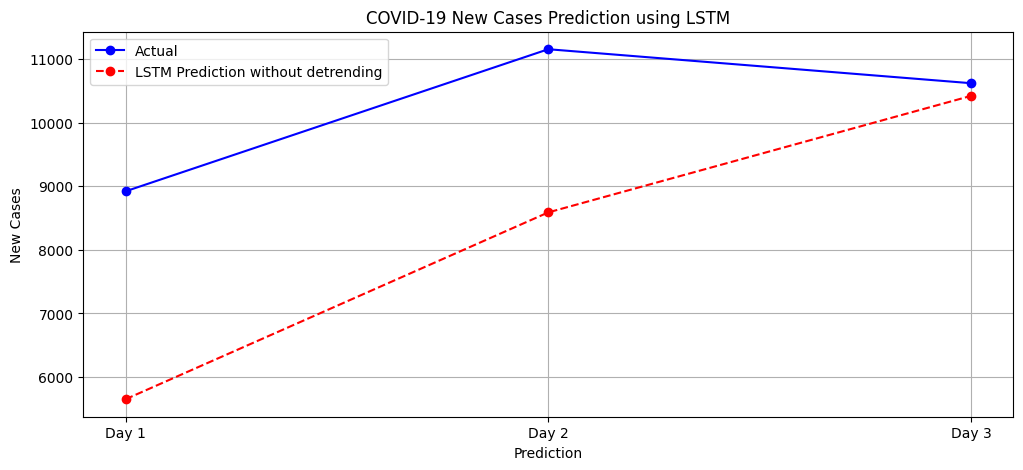

In [479]:
# Visualize the predictions as shown in Figure 6

days = ["Day 1", "Day 2", "Day 3"]
actual_new_cases = actual_future_cases
predicted_new_cases = future_predictions

plt.figure(figsize=(12, 5))
plt.plot(days, actual_new_cases, marker='o', linestyle='-', color='blue', label='Actual')
plt.plot(days, predicted_new_cases, marker='o', linestyle='--', color='red', label='LSTM Prediction without detrending')

plt.title('COVID-19 New Cases Prediction using LSTM')
plt.xlabel('Prediction')
plt.ylabel('New Cases')
plt.legend()

plt.grid(True)
plt.show()
